In [1]:
#---------------------------------------------------------------------------------
#                                 _             _      
#                                | |_  ___ _ __(_)__ _ 
#                                | ' \/ -_) '_ \ / _` |
#                                |_||_\___| .__/_\__,_|
#                                         |_|          
#
#---------------------------------------------------------------------------------
#
# Company: HEPIA // HES-SO
# Engineer: Laurent Gantel <laurent.gantel@hesge.ch>
# 
# Project Name: Unleashing the Full Potential of 
#               High-Performance Cherenkov Telescopes
#               with Fully-Digital Solid-State Sensors Camera
#
# File: 0.2_create_models.ipynb
# Description: Notebook for creating models using CTLearn Manager
#
# Last update: 2025-09-04
#
#--------------------------------------------------------------------------------

# CTLearn Model Managers

In [2]:
import sys
import os
import importlib
import glob
import hdf5plugin, h5py
import pandas as pd

In [3]:
# Custom tools
tools_path = os.path.join("../tools")
if tools_path not in sys.path:
    sys.path.append(tools_path)

import tools.CTLearnMgrConfig as CTLearnMgrConfig
importlib.reload(CTLearnMgrConfig)

from ctlearn_manager import CTLearnModelManager, DataSample, load_model_from_index

The first step is to create your ctlearn_model_index file (the Manager will create it for you if it does not exist). It is a HDF5 file containing a table per model. It contains one table per model, regardless of the task it is used for. The parameters table contains the general information about your model, such as its name, directory, reconstruction task, channels, telescopes, and training epochs. Other tables store the training and testing data, the IRFs, and the DL2 files for MC and real data. That way, CTLearn Manager can easily retrieve all relevant data for the plots and IRF production explained below, without the user needing to remember.

In [4]:
ctlearn_mgr_config = CTLearnMgrConfig.CTLearnMgrConfig()
ctlearn_mgr_config.load_config('../config/ctlearnmgr_config.yml')
ctlearn_mgr_config.print_config()

# Create the model index file
ctlearn_mgr_config.create_model_index_file()

Base Directory: /home/hugo/TM
Simtel Relative Directory: data
Training Samples Directory: samples
Workspace Directory: ml
Simtel Path: /home/hugo/TM/data
Training Samples Path: /home/hugo/TM/data/samples
Workspace Path: /home/hugo/TM/ml
Model Index File: /home/hugo/TM/ml/ctlearn_models_index.h5
Model index file already exists at: /home/hugo/TM/ml/ctlearn_models_index.h5


In [5]:
# Define directories containing training samples
gammas_train_dir = os.path.join(ctlearn_mgr_config.training_samples_path, 'gamma', 'train')
protons_train_dir = os.path.join(ctlearn_mgr_config.training_samples_path, 'proton', 'train')

In [6]:
# Training samples, as many as you have directions and particle types, here we have 2 particle types and one direction
training_samples = [
    DataSample(
        directory=gammas_train_dir,
        pattern="gamma*.h5"
    ),
    DataSample(
        directory=protons_train_dir,
        pattern="proton*.h5"
   ),
]
for sample in training_samples:
    print("Directory:", sample.directory)
    print("Pattern:", sample.pattern)
    files = glob.glob(f"{sample.directory}/{sample.pattern}")
    print(f"Sample in {sample.directory}:")
    print("Found files:", len(files))

Checking files for particle type and pointing: 100%|█████████████████████████████████| 12/12 [00:00<00:00, 110.70file/s]


	 -> gamma_diffuse @ (20.0 deg, 175.1963 deg)


Checking files for particle type and pointing: 100%|█████████████████████████████████| 12/12 [00:00<00:00, 118.10file/s]

	 -> proton @ (20.0 deg, 175.1963 deg)
Directory: /home/hugo/TM/data/samples/gamma/train
Pattern: gamma*.h5
Sample in /home/hugo/TM/data/samples/gamma/train:
Found files: 12
Directory: /home/hugo/TM/data/samples/proton/train
Pattern: proton*.h5
Sample in /home/hugo/TM/data/samples/proton/train:
Found files: 12


In [7]:
# General parameters
reco = "type"  # ['energy', 'type', 'cameradirection', 'skydirection']
model_parameters = {
    "model_nickname": f"{reco}_tel2_20deg_20",
    "model_dir": os.path.join(ctlearn_mgr_config.workspace_path),  # Main directory, will contain a new directory with you model, named after the model_nickname, will be created for you.
    
    # model_dir
    #     ├── model_nickname
    #     │   ├── model_nickname_v0
    #     │   ├── model_nickname_v1
    #     │   ├── model_nickname_v2

    "reco": reco,  # ['energy', 'type', 'cameradirection', 'skydirection']
    "telescope_names": ["Digicam"],  # List of telescopes names
    "telescope_ids": [2],  # List of telescope ids
    "max_training_epochs": 20,  # Can be changed later for training.
    "training_samples": training_samples,
    "stereo": False,  # True if stereo reconstruction, False if mono.
    #### OPTIONAL PARAMETERS
    # 'channels' : ['cleaned_image', 'cleaned_relative_peak_time'], # Order matters. # Default is ['cleaned_image', 'cleaned_relative_peak_time']
    'min_telescopes' : 1, # Minimum number of triggered telescopes for each events to be used in the model, if >=2, model will be stereo.
    # 'notes' : "Tel2 model for 20deg zenith distance",
}
new_model = CTLearnModelManager(model_parameters, ctlearn_mgr_config.model_index_file)

✅ Model nickname type_tel2_20deg_20 added to table
🧠 Model name: type_tel2_20deg_20


In order to check if your model is correctly set up, you can plot the zenith and azimuth ranges of your training data, as well as the training nodes.

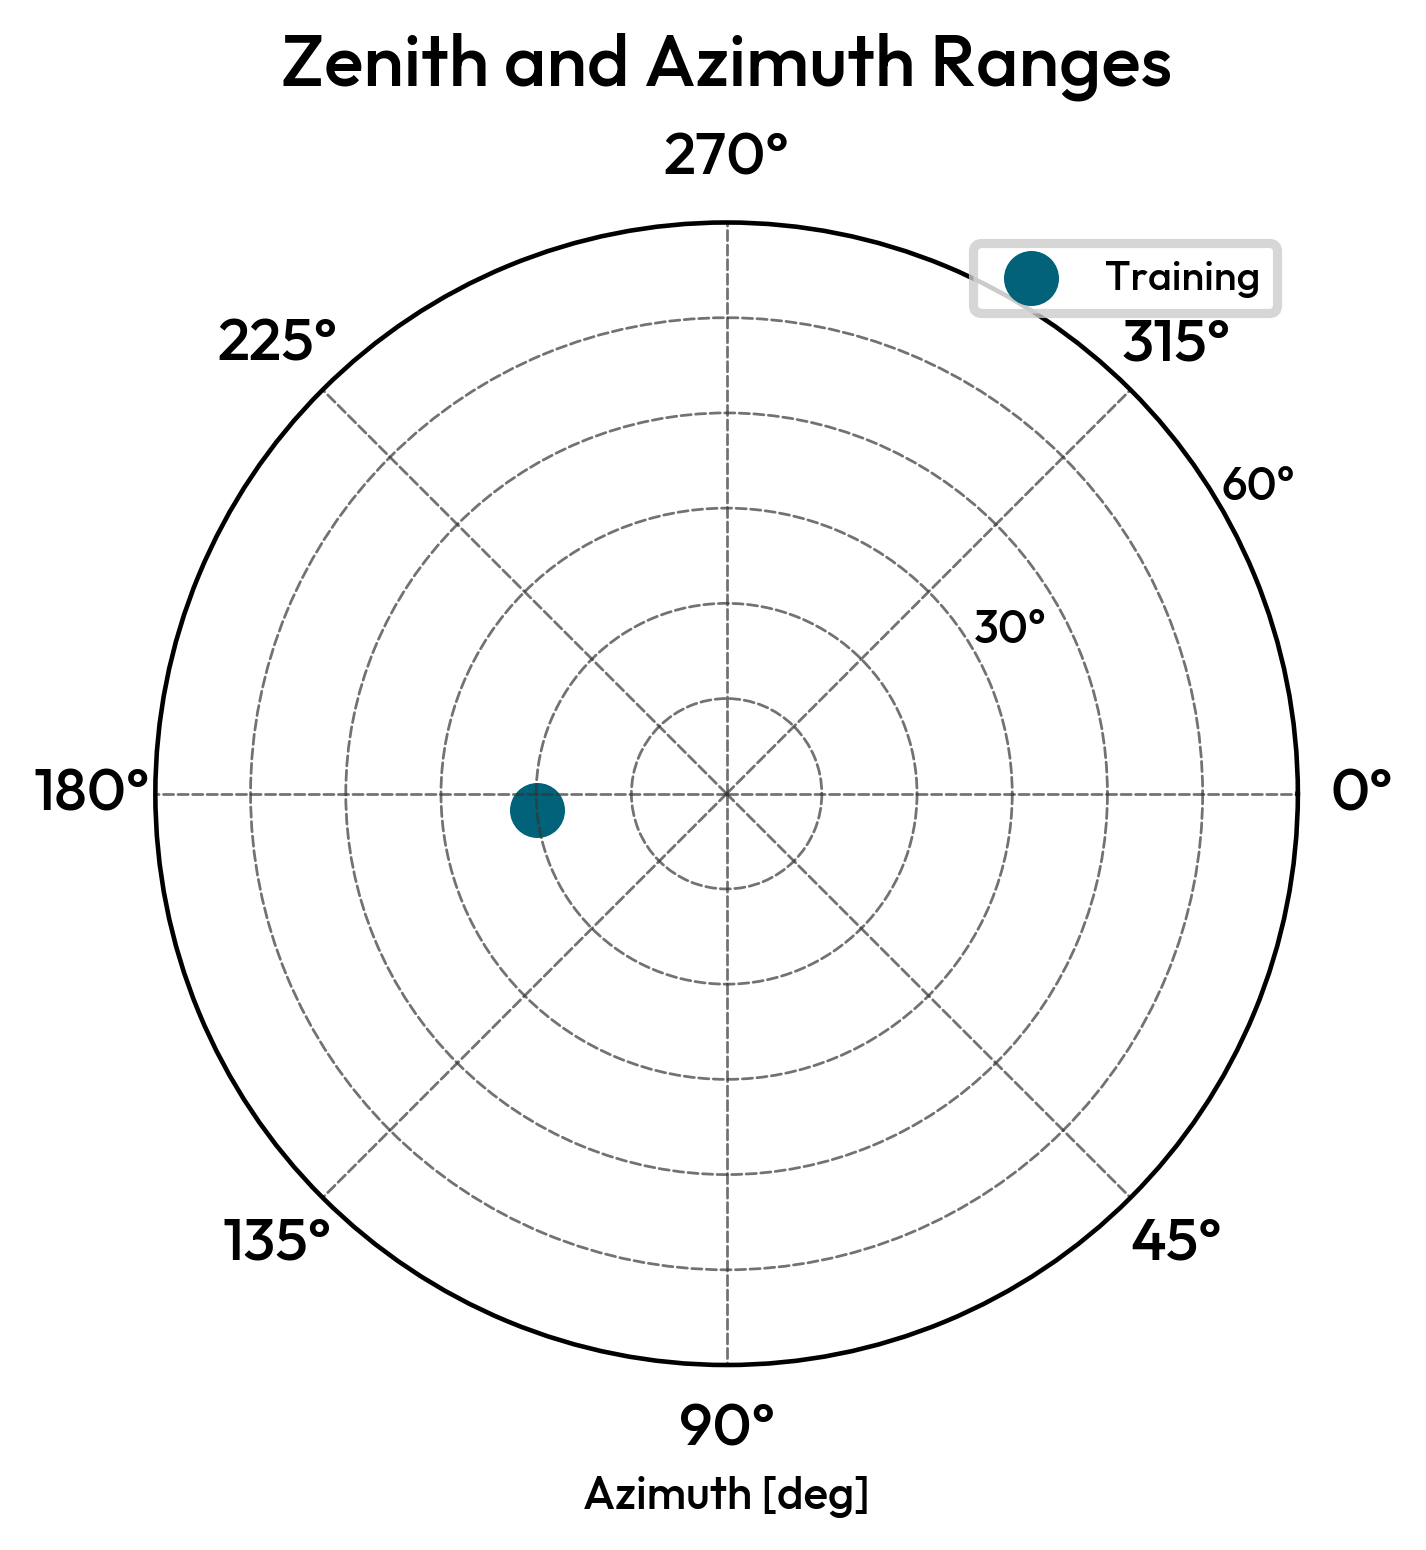

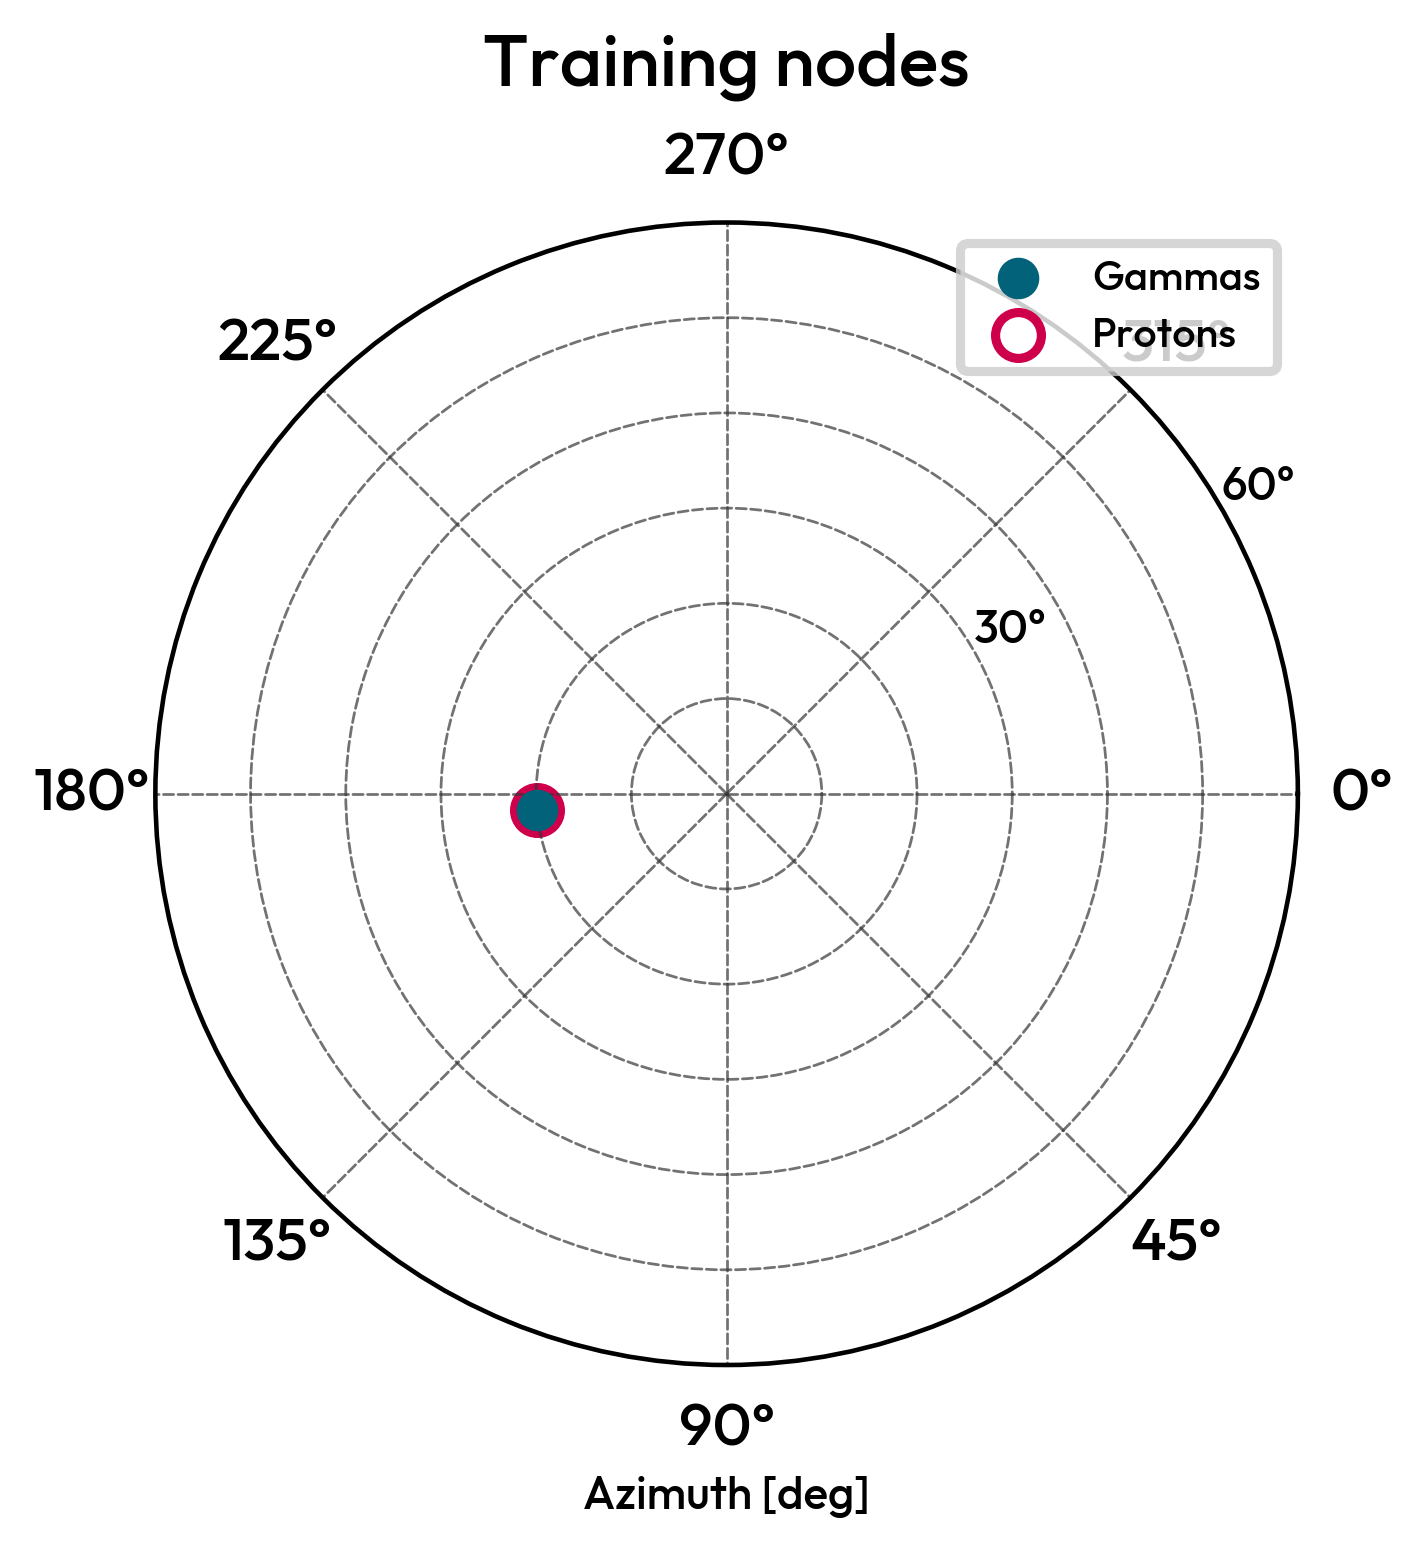

In [8]:
new_model.plot_zenith_azimuth_ranges()
new_model.plot_training_nodes()

In [9]:
# Explore content of h5
file = os.path.join(ctlearn_mgr_config.model_index_file)
with h5py.File(file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = False
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)
    params = f["energy_tel2_20deg/parameters"][:]
    print(params.dtype)
    params_df = pd.DataFrame(params)


Keys in file: ['energy_tel2_20deg', 'skydirection_tel2_20deg', 'type_tel2_20deg', 'type_tel2_20deg_20']
[('model_nickname', 'S256'), ('model_dir', 'S256'), ('reco', 'S256'), ('channels', 'S256'), ('telescope_names', 'S256'), ('telescope_ids', 'S256'), ('notes', 'S256'), ('max_training_epochs', '<i8'), ('min_telescopes', '<i8'), ('stereo', '?')]


0    b"['cleaned_image', 'cleaned_relative_peak_tim...
Name: channels, dtype: object

0    b"['cleaned_image', 'cleaned_relative_peak_tim...
Name: channels, dtype: object
